# Continuous DP
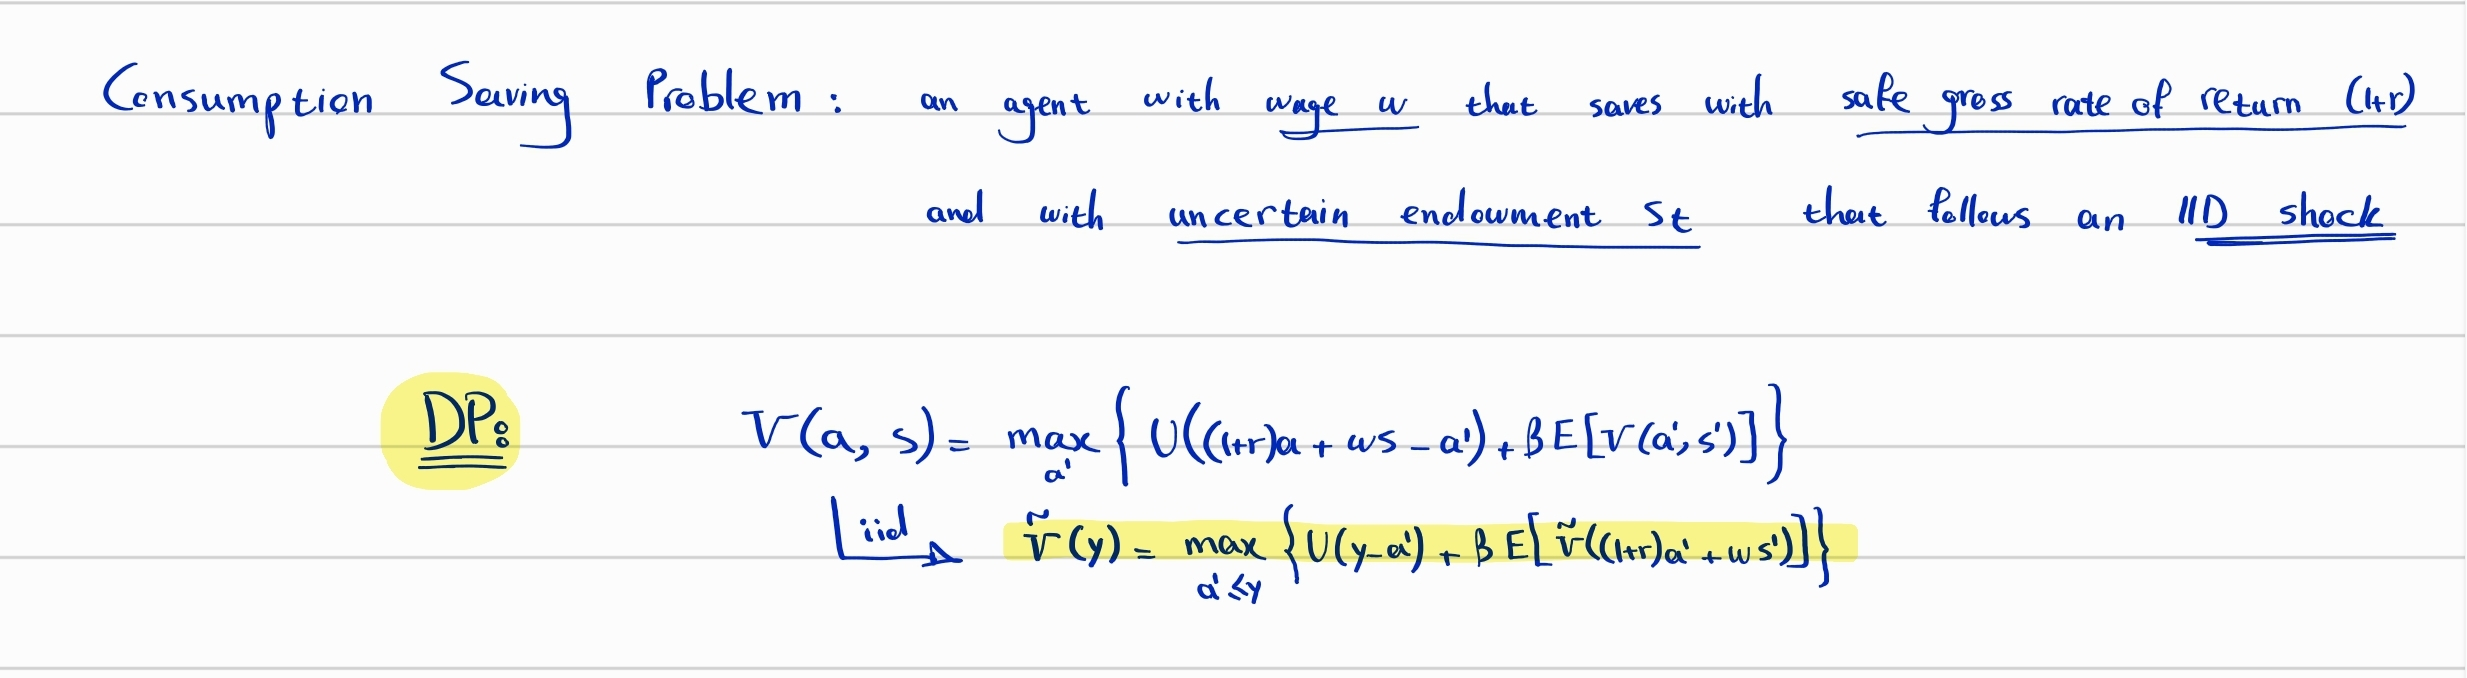

In [1]:
from joblib import Parallel, delayed
import numpy as np
from numpy import interp
from scipy.optimize import fsolve, fminbound
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [2]:
beta = 0.95
# r = 1 / beta - 1 # To have SS
r = 0.03
m, sigma = 1.0, 0.4
w = 1

a_ss_guess = c_ss_guess =  m * w

In [3]:
R = 100
next_s_sample = np.linspace(m - sigma * 12 ** 0.5 / 2, m + sigma * 12 ** 0.5 / 2, num=R)

In [4]:
%%time

from numpy import array as np_array
from numpy import log as np_log
# Importing increases performance of Parallel!

F = lambda current_income, a_prime: np_log(current_income - a_prime)
T = lambda x: x

def value_func_iterate(current_income_grid, v0_grid):
    # x=x in lambda!
    # Evaluation Time
    # https://realpython.com/python-lambda/
    a_prime_grid = np_array(Parallel(n_jobs=n_jobs, verbose=0, return_as='list', batch_size=grid_size // n_jobs)(
        delayed(fminbound)(
            func=lambda a_prime, current_income=current_income: -(F(current_income, a_prime) + beta * interp(next_s_sample * w + (1 + r) * a_prime, current_income_grid, v0_grid).mean()),
            x1=0, x2=T(current_income)) for current_income in current_income_grid))
    v_grid_updated = np_array(
        F(current_income_grid, a_prime_grid) + beta * interp(np.vstack(grid_size * [next_s_sample]).T * w + (1 + r) * np.vstack(R * [a_prime_grid]),
                                          current_income_grid, v0_grid).mean(axis=0))

    return a_prime_grid, v_grid_updated


n_jobs = 10
grid_size = 1_000

temp = np.linspace(0.0, 4 * a_ss_guess, grid_size)
current_income_grid = np.linspace(m - sigma * 12 ** 0.5 / 2, m + sigma * 12 ** 0.5 / 2, num=grid_size) * w + (1 + r) * temp
current_c_grid = np.linspace(0.0, 4 * c_ss_guess, grid_size)
a_prime_grid = current_income_grid - current_c_grid
v_grid = np_log(current_c_grid) / (1 - beta)

max_iter = 200
tol = 10 ** -5
# g is a function from current income to saving (a')
for _ in tqdm.tqdm(range(max_iter), ncols=50):
    g, v_grid = value_func_iterate(current_income_grid=current_income_grid, v0_grid=v_grid)
    err = np.max(np.abs(g - a_prime_grid))
    a_prime_grid = g
    if err < tol:
        break
current_c_grid = current_income_grid - a_prime_grid
expected_next_income= m * w + (1 + r) * a_prime_grid
ss_index = np.argmin(np.abs(current_income_grid - expected_next_income))

a_ss_guess = c_ss_guess

print(f'Found income_ss ({current_income_grid[ss_index]})')
print(f'Found a_ss ({a_prime_grid[ss_index]})')
print(f'Found c_ss ({current_c_grid[ss_index]})')

<timed exec>:30: RuntimeWarning: divide by zero encountered in log
 32%|███▊        | 63/200 [00:12<00:26,  5.21it/s]

Found income_ss (1.6188338048614521)
Found a_ss (0.6003899572858095)
Found c_ss (1.0184438475756425)
CPU times: user 10.6 s, sys: 805 ms, total: 11.4 s
Wall time: 12.1 s


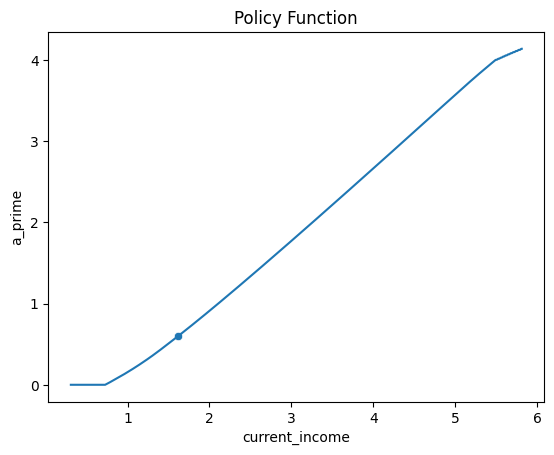

In [5]:
sns.lineplot(x=current_income_grid, y=a_prime_grid)
sns.scatterplot(x=[current_income_grid[ss_index]], y=[a_prime_grid[ss_index]])
plt.xlabel('current_income')
plt.title('Policy Function')
plt.ylabel("a_prime");

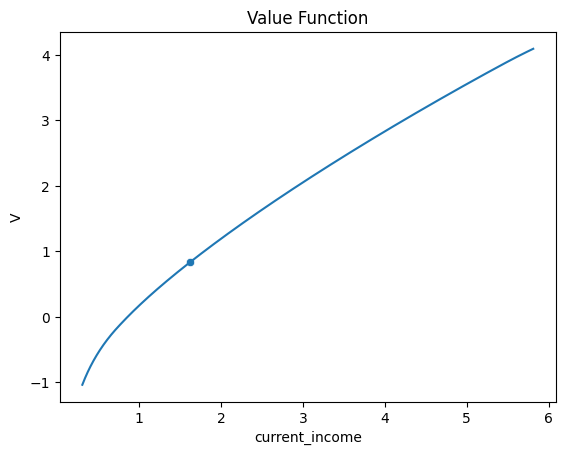

In [6]:
sns.lineplot(x=current_income_grid, y=v_grid)
sns.scatterplot(x=[current_income_grid[ss_index]], y=[v_grid[ss_index]])
plt.xlabel('current_income')
plt.title('Value Function')
plt.ylabel("V");

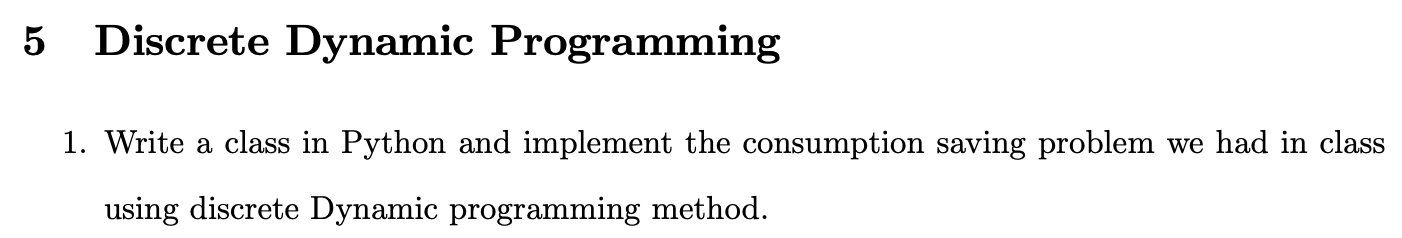

# Discrete DP
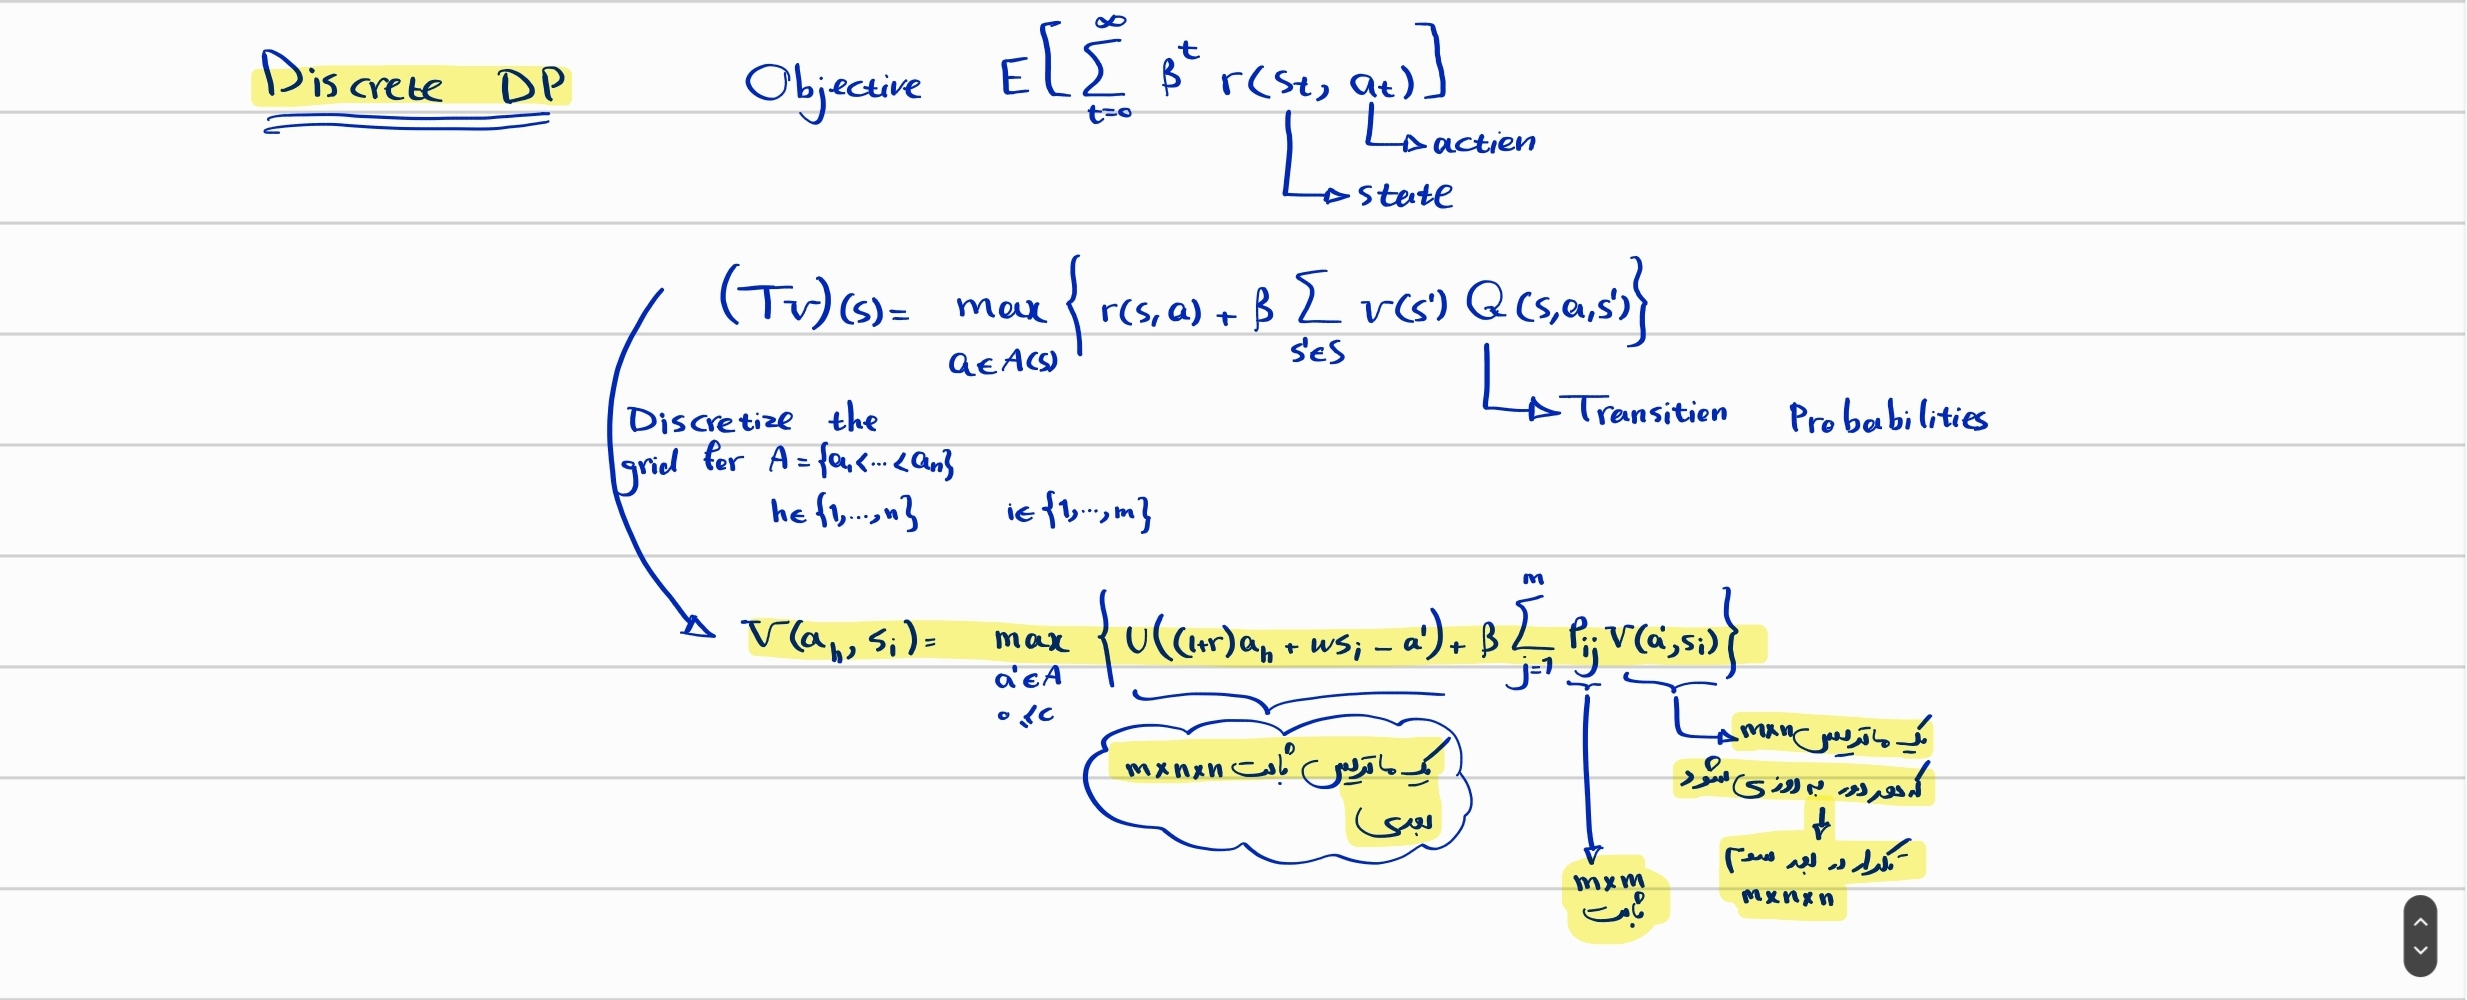

In [1]:
from joblib import Parallel, delayed
import numpy as np
from numpy import interp
from scipy.optimize import fsolve, fminbound
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from numpy import array as np_array
from numpy import log as np_log

beta = 0.95
# r = 1 / beta - 1 # To have SS
r = 0.03
m, sigma = 1.0, 0.4
w = 1

a_ss_guess = c_ss_guess =  m * w

In [3]:
grid_size, R = 1_000, 100

a_grid = np.linspace(0.0, 4 * a_ss_guess, grid_size)
s_grid = np.linspace(m - sigma * 12 ** 0.5 / 2, m + sigma * 12 ** 0.5 / 2, num=R)

def c_function(a_index, s_index, a_prime_index):
    return (1 + r) * a_grid[a_index] + w * s_grid[s_index] - a_grid[a_prime_index]

C = np.fromfunction(c_function, (grid_size, R, grid_size), dtype=int)
U = C.copy()
U[C>0] = np_log(C[C>0])
U[C<=0] = -np.inf # imposes constraints on the optimization process

In [4]:
P = np.ones((grid_size, R, R)) * (1 / R)
v_grid_2d = np.fromfunction(lambda a_index, s_index: np_log(r * a_grid[a_index] + w * s_grid[s_index]) / (1 - beta), (grid_size, R), dtype=int)
a_prime_2d = np.fromfunction(lambda a_index, s_index: a_index, (grid_size, R), dtype=int)
# Initial policy is to have constant "a" over time.

In [5]:
%%time
for _ in tqdm.tqdm(range(200)):
    # https://numpy.org/doc/stable/reference/generated/numpy.dot.html
    # If a is an N-D array and b is an M-D array (where M>=2), it is a sum product over the last axis of a and the second-to-last axis of b:
    # dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
    
    t = U + beta * P.dot(v_grid_2d.T) # TODO: This is the time consuming part. how to optimize???
    
    a_prime_2d_new = np.argmax(t, axis=2)

    i, j = np.indices(a_prime_2d_new.shape)
    v_grid_2d_new = t[i, j, a_prime_2d_new]
    
    err = np.mean(np.abs(v_grid_2d - v_grid_2d_new))
    success_ratio = (a_prime_2d == a_prime_2d_new).sum() / (grid_size * R)
    
    # print(success_ratio, err, v_grid_2d_new[10, 10])
    
    v_grid_2d = v_grid_2d_new
    a_prime_2d = a_prime_2d_new

    if err < 10 ** -3 and success_ratio == 1.0:
        break

 42%|████████████████████████████████████████████████████████████████████████▋                                                                                                    | 84/200 [04:56<06:49,  3.53s/it]

CPU times: user 4min 35s, sys: 20.8 s, total: 4min 56s
Wall time: 4min 56s


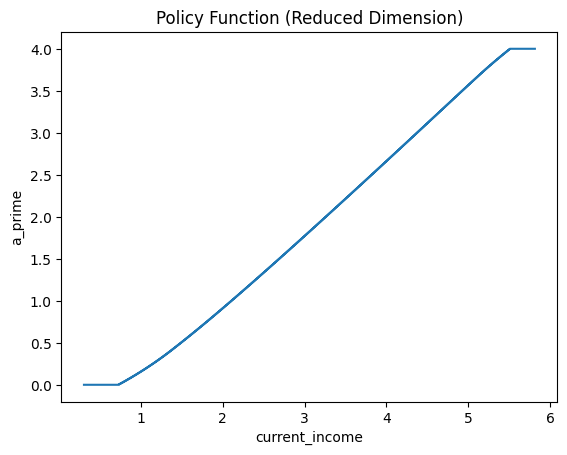

In [6]:
point_income, point_a_prime, point_value = [], [], []
for a_index in range(grid_size):
    for s_index in range(R):
        income = (1 + r) * a_grid[a_index] + w * s_grid[s_index]
        next_a_index = a_prime_2d[a_index, s_index]
        c =  income - a_grid[next_a_index]
        v = v_grid_2d[a_index, s_index]
        point_income.append(income)
        point_a_prime.append(a_grid[next_a_index])
        point_value.append(v)

sns.lineplot(x=point_income, y=point_a_prime)
plt.xlabel('current_income')
plt.title('Policy Function (Reduced Dimension)')
plt.ylabel("a_prime");

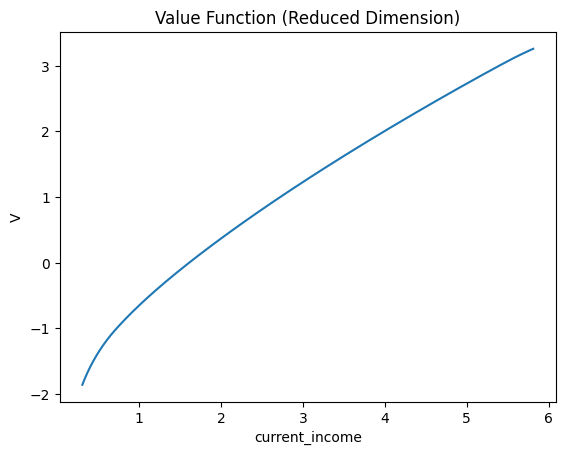

In [7]:
sns.lineplot(x=point_income, y=point_value)
plt.xlabel('current_income')
plt.title('Value Function (Reduced Dimension)')
plt.ylabel("V");

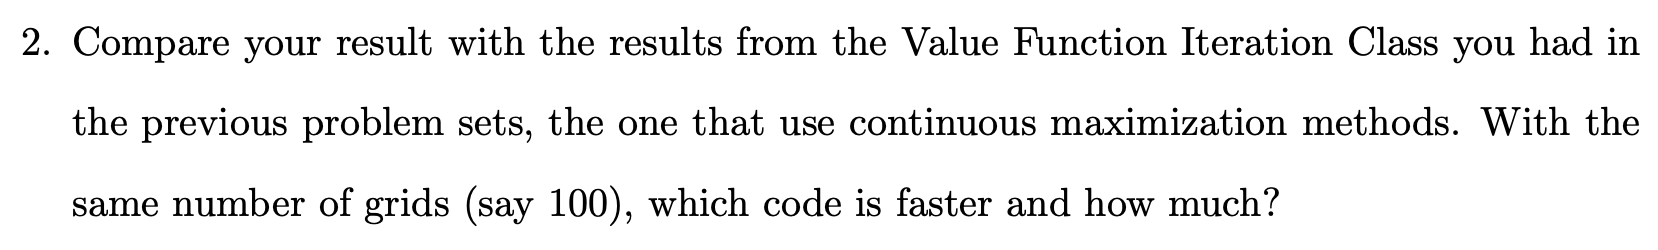

In the previous section, I implemented both continuous and discrete dynamic programming. Surprisingly, the continuous model was significantly faster! With a grid size of 1,000 and R of 100, the continuous code achieved a precision of $10^{-5}$ error in just 12.1 seconds using parallel computation across 10 CPU cores via joblib.Parallel. In contrast, the discrete model only reached $10^{-3}$ precision in 296 seconds, without the benefit of parallel processing.

The superior performance of the continuous model can be attributed to two main factors:

- Parallel Computation: The rapid performance of the continuous model is largely due to the use of parallel computation. I employed joblib.Parallel to effectively utilize 10 CPU cores. However, implementing a similar parallel strategy in the discrete model, particularly during matrix multiplication, remains a challenge. Further investigation into parallelizable methods for these calculations could significantly enhance the efficiency of the discrete model.
- Dimensional Reduction: In the continuous model, we leveraged the fact that shocks are independent and identically distributed (iid) to reduce the model's dimensionality from (a, s) to (y). This simplification was not applied in the discrete model, resulting in higher computational complexity.

Further exploration into how parallel processing can be integrated into the discrete model, particularly for operations like matrix multiplication, could provide significant performance improvements. This area seems ripe for additional research and might benefit from consultation with experts in computational optimization or a review of libraries designed for parallel matrix operations.

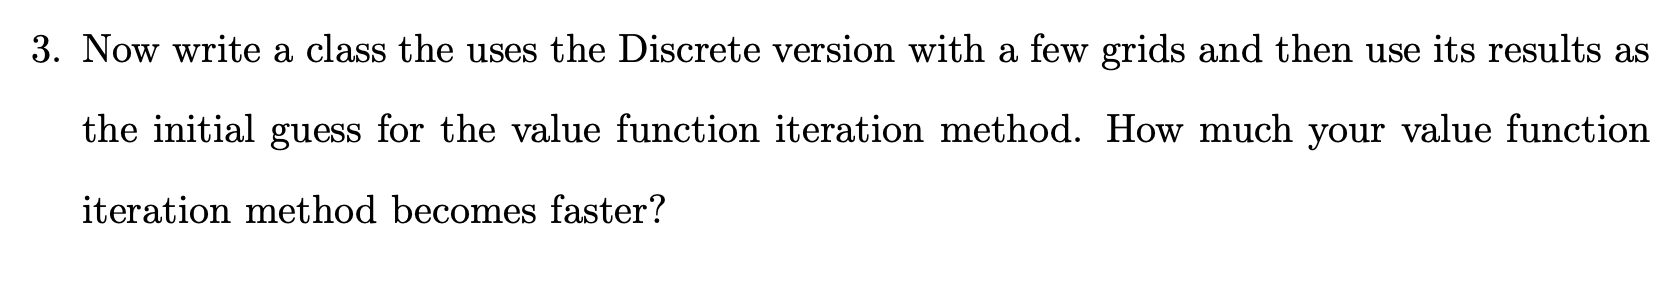

As mentioned previously, the continuous model we solved in the last problem set was significantly faster due to its reduced dimensionality, unlike the discrete model. The question proposes an interesting approach: using the results from the discrete model as initial guesses for the value function iteration in a continuous model. This method could potentially accelerate the convergence of the value function iteration by starting closer to the optimal solution.

However, to effectively implement and test this approach, we would first need to develop a continuous model without reduced dimensionality, which was not covered in the previous problem set. Implementing such a model would require adjusting our current framework to accommodate a full-dimensional continuous space, which could be computationally intensive but interesting to explore.

If this setup were in place, we could then benchmark the performance improvement by comparing the number of iterations and computational time required to converge to an optimal solution with and without using the discrete model's results as initial guesses.

As this specific implementation has not yet been developed, a practical next step would be to design and test both models accordingly. This would provide a clear comparison and quantify how much faster the value function iteration becomes with the proposed initialization strategy.